# DS 320 PROJECT - YOUTUBE HATE PREDICTION
Group B5: Areej Soleja, Amish Gautam, and Alvaro Tapia Huaman


In [1]:
# Importing all the necessary packages and files
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot
from scipy.io import loadmat

import warnings
# ignore all warnings
warnings.filterwarnings("ignore")

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

from sklearn.feature_extraction.text import TfidfVectorizer

import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Retrieving and cleaning the datasets
Used the US videos dataset, and the US comments dataset.

In [3]:
# Reading the datasets
US_stats = pd.read_csv(os.path.join('/content/drive/My Drive/P320', 'USvideos.csv'), error_bad_lines=False)
US_comments = pd.read_csv(os.path.join('/content/drive/My Drive/P320', 'UScomments.csv'), error_bad_lines=False)
td_idf = pd.read_csv(os.path.join('/content/drive/My Drive/P320', 'tfidf_score.csv'), error_bad_lines=False)

Skipping line 2401: expected 11 fields, saw 21
Skipping line 2800: expected 11 fields, saw 21
Skipping line 5297: expected 11 fields, saw 12
Skipping line 5299: expected 11 fields, saw 12
Skipping line 5300: expected 11 fields, saw 12
Skipping line 5301: expected 11 fields, saw 12

Skipping line 41589: expected 4 fields, saw 11
Skipping line 51628: expected 4 fields, saw 7
Skipping line 114465: expected 4 fields, saw 5

Skipping line 142496: expected 4 fields, saw 8
Skipping line 189732: expected 4 fields, saw 6
Skipping line 245218: expected 4 fields, saw 7

Skipping line 388430: expected 4 fields, saw 5



In [4]:
US_df = result_df = pd.merge(US_stats, US_comments, on='video_id', how='left')
US_df.head()

,video_id,title,channel_title,category_id,tags,views,likes_x,dislikes,comment_total,thumbnail_link,date,comment_text,likes_y,replies
0,XpVt6Z1Gjjo,1 YEAR OF VLOGGING -- HOW LOGAN PAUL CHANGED Y...,Logan Paul Vlogs,24,logan paul vlog|logan paul|logan|paul|olympics...,4394029,320053,5931,46245,https://i.ytimg.com/vi/XpVt6Z1Gjjo/default.jpg,13.09,Logan Paul it's yo big day ‼️‼️‼️,4,0
1,XpVt6Z1Gjjo,1 YEAR OF VLOGGING -- HOW LOGAN PAUL CHANGED Y...,Logan Paul Vlogs,24,logan paul vlog|logan paul|logan|paul|olympics...,4394029,320053,5931,46245,https://i.ytimg.com/vi/XpVt6Z1Gjjo/default.jpg,13.09,I've been following you from the start of your...,3,0
2,XpVt6Z1Gjjo,1 YEAR OF VLOGGING -- HOW LOGAN PAUL CHANGED Y...,Logan Paul Vlogs,24,logan paul vlog|logan paul|logan|paul|olympics...,4394029,320053,5931,46245,https://i.ytimg.com/vi/XpVt6Z1Gjjo/default.jpg,13.09,Say hi to Kong and maverick for me,3,0
3,XpVt6Z1Gjjo,1 YEAR OF VLOGGING -- HOW LOGAN PAUL CHANGED Y...,Logan Paul Vlogs,24,logan paul vlog|logan paul|logan|paul|olympics...,4394029,320053,5931,46245,https://i.ytimg.com/vi/XpVt6Z1Gjjo/default.jpg,13.09,MY FAN . attendance,3,0
4,XpVt6Z1Gjjo,1 YEAR OF VLOGGING -- HOW LOGAN PAUL CHANGED Y...,Logan Paul Vlogs,24,logan paul vlog|logan paul|logan|paul|olympics...,4394029,320053,5931,46245,https://i.ytimg.com/vi/XpVt6Z1Gjjo/default.jpg,13.09,trending 😉,3,0


In [5]:
US_df = US_df.rename(columns={'likes_x': 'video_likes', 'likes_y': 'com_likes'})
US_df = US_df.drop(['thumbnail_link', 'replies'], axis=1)

In [6]:
print(US_df.shape)

(2941199, 12)


In [7]:
US_df = US_df.drop_duplicates()
print(US_df.shape)

(1991912, 12)


In [8]:
US_df.head()

,video_id,title,channel_title,category_id,tags,views,video_likes,dislikes,comment_total,date,comment_text,com_likes
0,XpVt6Z1Gjjo,1 YEAR OF VLOGGING -- HOW LOGAN PAUL CHANGED Y...,Logan Paul Vlogs,24,logan paul vlog|logan paul|logan|paul|olympics...,4394029,320053,5931,46245,13.09,Logan Paul it's yo big day ‼️‼️‼️,4
1,XpVt6Z1Gjjo,1 YEAR OF VLOGGING -- HOW LOGAN PAUL CHANGED Y...,Logan Paul Vlogs,24,logan paul vlog|logan paul|logan|paul|olympics...,4394029,320053,5931,46245,13.09,I've been following you from the start of your...,3
2,XpVt6Z1Gjjo,1 YEAR OF VLOGGING -- HOW LOGAN PAUL CHANGED Y...,Logan Paul Vlogs,24,logan paul vlog|logan paul|logan|paul|olympics...,4394029,320053,5931,46245,13.09,Say hi to Kong and maverick for me,3
3,XpVt6Z1Gjjo,1 YEAR OF VLOGGING -- HOW LOGAN PAUL CHANGED Y...,Logan Paul Vlogs,24,logan paul vlog|logan paul|logan|paul|olympics...,4394029,320053,5931,46245,13.09,MY FAN . attendance,3
4,XpVt6Z1Gjjo,1 YEAR OF VLOGGING -- HOW LOGAN PAUL CHANGED Y...,Logan Paul Vlogs,24,logan paul vlog|logan paul|logan|paul|olympics...,4394029,320053,5931,46245,13.09,trending 😉,3


In [9]:
US_df = US_df.dropna()
print(US_df.shape)

(1991572, 12)


# Calculating the Sentiment per comment per video
Code modified from ChatGPT

In [10]:
nltk.download('vader_lexicon')

# Create an instance of the sentiment analyzer
sid = SentimentIntensityAnalyzer()

# Define a function to get the sentiment of a comment
def get_sentiment(comment):
    scores = sid.polarity_scores(comment)
    sentiment = scores['compound']
    return sentiment

# Apply the function to the 'comment_text' column
US_df['comment_sentiment'] = US_df['comment_text'].apply(get_sentiment)

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [11]:
US_df.head(10)

,video_id,title,channel_title,category_id,tags,views,video_likes,dislikes,comment_total,date,comment_text,com_likes,comment_sentiment
0,XpVt6Z1Gjjo,1 YEAR OF VLOGGING -- HOW LOGAN PAUL CHANGED Y...,Logan Paul Vlogs,24,logan paul vlog|logan paul|logan|paul|olympics...,4394029,320053,5931,46245,13.09,Logan Paul it's yo big day ‼️‼️‼️,4,0.0000
1,XpVt6Z1Gjjo,1 YEAR OF VLOGGING -- HOW LOGAN PAUL CHANGED Y...,Logan Paul Vlogs,24,logan paul vlog|logan paul|logan|paul|olympics...,4394029,320053,5931,46245,13.09,I've been following you from the start of your...,3,0.0000
2,XpVt6Z1Gjjo,1 YEAR OF VLOGGING -- HOW LOGAN PAUL CHANGED Y...,Logan Paul Vlogs,24,logan paul vlog|logan paul|logan|paul|olympics...,4394029,320053,5931,46245,13.09,Say hi to Kong and maverick for me,3,0.0000
3,XpVt6Z1Gjjo,1 YEAR OF VLOGGING -- HOW LOGAN PAUL CHANGED Y...,Logan Paul Vlogs,24,logan paul vlog|logan paul|logan|paul|olympics...,4394029,320053,5931,46245,13.09,MY FAN . attendance,3,0.4648
4,XpVt6Z1Gjjo,1 YEAR OF VLOGGING -- HOW LOGAN PAUL CHANGED Y...,Logan Paul Vlogs,24,logan paul vlog|logan paul|logan|paul|olympics...,4394029,320053,5931,46245,13.09,trending 😉,3,0.0000
5,XpVt6Z1Gjjo,1 YEAR OF VLOGGING -- HOW LOGAN PAUL CHANGED Y...,Logan Paul Vlogs,24,logan paul vlog|logan paul|logan|paul|olympics...,4394029,320053,5931,46245,13.09,#1 on trending AYYEEEEE,3,0.0000
6,XpVt6Z1Gjjo,1 YEAR OF VLOGGING -- HOW LOGAN PAUL CHANGED Y...,Logan Paul Vlogs,24,logan paul vlog|logan paul|logan|paul|olympics...,4394029,320053,5931,46245,13.09,The end though 😭👍🏻❤️,4,0.0000
7,XpVt6Z1Gjjo,1 YEAR OF VLOGGING -- HOW LOGAN PAUL CHANGED Y...,Logan Paul Vlogs,24,logan paul vlog|logan paul|logan|paul|olympics...,4394029,320053,5931,46245,13.09,#1 trending!!!!!!!!!,3,0.0000
8,XpVt6Z1Gjjo,1 YEAR OF VLOGGING -- HOW LOGAN PAUL CHANGED Y...,Logan Paul Vlogs,24,logan paul vlog|logan paul|logan|paul|olympics...,4394029,320053,5931,46245,13.09,Happy one year vlogaversary,3,0.5719
9,XpVt6Z1Gjjo,1 YEAR OF VLOGGING -- HOW LOGAN PAUL CHANGED Y...,Logan Paul Vlogs,24,logan paul vlog|logan paul|logan|paul|olympics...,4394029,320053,5931,46245,13.09,You and your shit brother may have single hand...,0,-0.7717


In [12]:
avg_df = US_df
avg_df["average_sentiment"] = avg_df.groupby('video_id')['comment_sentiment'].transform('mean')

In [13]:
avg_df.head(10)

,video_id,title,channel_title,category_id,tags,views,video_likes,dislikes,comment_total,date,comment_text,com_likes,comment_sentiment,average_sentiment
0,XpVt6Z1Gjjo,1 YEAR OF VLOGGING -- HOW LOGAN PAUL CHANGED Y...,Logan Paul Vlogs,24,logan paul vlog|logan paul|logan|paul|olympics...,4394029,320053,5931,46245,13.09,Logan Paul it's yo big day ‼️‼️‼️,4,0.0000,0.086394
1,XpVt6Z1Gjjo,1 YEAR OF VLOGGING -- HOW LOGAN PAUL CHANGED Y...,Logan Paul Vlogs,24,logan paul vlog|logan paul|logan|paul|olympics...,4394029,320053,5931,46245,13.09,I've been following you from the start of your...,3,0.0000,0.086394
2,XpVt6Z1Gjjo,1 YEAR OF VLOGGING -- HOW LOGAN PAUL CHANGED Y...,Logan Paul Vlogs,24,logan paul vlog|logan paul|logan|paul|olympics...,4394029,320053,5931,46245,13.09,Say hi to Kong and maverick for me,3,0.0000,0.086394
3,XpVt6Z1Gjjo,1 YEAR OF VLOGGING -- HOW LOGAN PAUL CHANGED Y...,Logan Paul Vlogs,24,logan paul vlog|logan paul|logan|paul|olympics...,4394029,320053,5931,46245,13.09,MY FAN . attendance,3,0.4648,0.086394
4,XpVt6Z1Gjjo,1 YEAR OF VLOGGING -- HOW LOGAN PAUL CHANGED Y...,Logan Paul Vlogs,24,logan paul vlog|logan paul|logan|paul|olympics...,4394029,320053,5931,46245,13.09,trending 😉,3,0.0000,0.086394
5,XpVt6Z1Gjjo,1 YEAR OF VLOGGING -- HOW LOGAN PAUL CHANGED Y...,Logan Paul Vlogs,24,logan paul vlog|logan paul|logan|paul|olympics...,4394029,320053,5931,46245,13.09,#1 on trending AYYEEEEE,3,0.0000,0.086394
6,XpVt6Z1Gjjo,1 YEAR OF VLOGGING -- HOW LOGAN PAUL CHANGED Y...,Logan Paul Vlogs,24,logan paul vlog|logan paul|logan|paul|olympics...,4394029,320053,5931,46245,13.09,The end though 😭👍🏻❤️,4,0.0000,0.086394
7,XpVt6Z1Gjjo,1 YEAR OF VLOGGING -- HOW LOGAN PAUL CHANGED Y...,Logan Paul Vlogs,24,logan paul vlog|logan paul|logan|paul|olympics...,4394029,320053,5931,46245,13.09,#1 trending!!!!!!!!!,3,0.0000,0.086394
8,XpVt6Z1Gjjo,1 YEAR OF VLOGGING -- HOW LOGAN PAUL CHANGED Y...,Logan Paul Vlogs,24,logan paul vlog|logan paul|logan|paul|olympics...,4394029,320053,5931,46245,13.09,Happy one year vlogaversary,3,0.5719,0.086394
9,XpVt6Z1Gjjo,1 YEAR OF VLOGGING -- HOW LOGAN PAUL CHANGED Y...,Logan Paul Vlogs,24,logan paul vlog|logan paul|logan|paul|olympics...,4394029,320053,5931,46245,13.09,You and your shit brother may have single hand...,0,-0.7717,0.086394


# Performing Data Integration and Selection
*   Removing all the repeated videos

*   Calculating Sentiment Label based on average sentiment

*   Performing TF IDF and adding it into the DataFrame

*   Creating columns for dislikes and likes ratios

*   And performing feature selection at the end


In [14]:
df = avg_df.sort_values(['video_id', 'views'], ascending=[True, False])

# Drop duplicate 'user_id' values and keep only the first row (highest 'visits')
df = avg_df.drop_duplicates(subset='video_id', keep='first')
df

,video_id,title,channel_title,category_id,tags,views,video_likes,dislikes,comment_total,date,comment_text,com_likes,comment_sentiment,average_sentiment
0,XpVt6Z1Gjjo,1 YEAR OF VLOGGING -- HOW LOGAN PAUL CHANGED Y...,Logan Paul Vlogs,24,logan paul vlog|logan paul|logan|paul|olympics...,4394029,320053,5931,46245,13.09,Logan Paul it's yo big day ‼️‼️‼️,4,0.0000,0.086394
801,cLdxuaxaQwc,My Response,PewDiePie,22,[none],5845909,576597,39774,170708,13.09,Love you Pewdiepie don't apologize your fine,0,0.5126,-0.020132
1600,WYYvHb03Eog,Apple iPhone X first look,The Verge,28,apple iphone x hands on|Apple iPhone X|iPhone ...,2642103,24975,4542,12829,13.09,What if I wanna unlock my phone while in the b...,0,0.0000,0.070321
2400,sjlHnJvXdQs,iPhone X (parody),jacksfilms,23,jacksfilms|parody|parodies|iphone|iphone x|iph...,1168130,96666,568,6666,13.09,Nothing's scarier than a guy replying to every...,3,0.0000,0.115051
3200,cMKX2tE5Luk,The Disaster Artist | Official Trailer HD | A24,A24,1,a24|a24 films|a24 trailers|independent films|t...,1311445,34507,544,3040,13.09,I'm sure I speak for everyone when I say the w...,3,0.3182,0.179144
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2900192,mv4MRmwXJMM,Kygo - Kids in Love (Audio) ft. The Night Game,KygoOfficialVEVO,10,Dance/House/Techno|Kids in Love|Kygo|Kygo feat...,1249946,57826,708,2129,22.10,I hope kygo will do songs like stargazing and ...,3,0.8930,0.253038
2903564,7_GaeAoLMWY,Keyshia Cole Performs Incapable,Wendy Williams,24,Keyshia Cole|wendy williams|the wendy williams...,106467,3140,123,637,22.10,🙄 that’s all she sing about is love songs n th...,0,0.7717,0.313223
2924730,S9VIKOuZcds,My Sweet Jax (Tribute to a Cat),Hot Dad,23,cat|feline|pets|beloved|family member|grief|gr...,25037,2846,11,537,22.10,"I tried to laugh, but cried instead. In the l...",3,-0.9062,0.144990
2925632,a5NIg5yyHWo,Pawn Stars: An Original 1978 Superman Costume ...,HISTORY,24,history|history channel|history shows|history ...,400104,2432,123,386,22.10,Unlimited energy machine \nExpert: its worth A...,3,0.8591,0.198645


In [15]:
# 1 for postive sentiment, 0 for negative sentiment
df["sentiment_label"] = df["average_sentiment"].apply(lambda x: 1 if x > 0 else 0)
df

,video_id,title,channel_title,category_id,tags,views,video_likes,dislikes,comment_total,date,comment_text,com_likes,comment_sentiment,average_sentiment,sentiment_label
0,XpVt6Z1Gjjo,1 YEAR OF VLOGGING -- HOW LOGAN PAUL CHANGED Y...,Logan Paul Vlogs,24,logan paul vlog|logan paul|logan|paul|olympics...,4394029,320053,5931,46245,13.09,Logan Paul it's yo big day ‼️‼️‼️,4,0.0000,0.086394,1
801,cLdxuaxaQwc,My Response,PewDiePie,22,[none],5845909,576597,39774,170708,13.09,Love you Pewdiepie don't apologize your fine,0,0.5126,-0.020132,0
1600,WYYvHb03Eog,Apple iPhone X first look,The Verge,28,apple iphone x hands on|Apple iPhone X|iPhone ...,2642103,24975,4542,12829,13.09,What if I wanna unlock my phone while in the b...,0,0.0000,0.070321,1
2400,sjlHnJvXdQs,iPhone X (parody),jacksfilms,23,jacksfilms|parody|parodies|iphone|iphone x|iph...,1168130,96666,568,6666,13.09,Nothing's scarier than a guy replying to every...,3,0.0000,0.115051,1
3200,cMKX2tE5Luk,The Disaster Artist | Official Trailer HD | A24,A24,1,a24|a24 films|a24 trailers|independent films|t...,1311445,34507,544,3040,13.09,I'm sure I speak for everyone when I say the w...,3,0.3182,0.179144,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2900192,mv4MRmwXJMM,Kygo - Kids in Love (Audio) ft. The Night Game,KygoOfficialVEVO,10,Dance/House/Techno|Kids in Love|Kygo|Kygo feat...,1249946,57826,708,2129,22.10,I hope kygo will do songs like stargazing and ...,3,0.8930,0.253038,1
2903564,7_GaeAoLMWY,Keyshia Cole Performs Incapable,Wendy Williams,24,Keyshia Cole|wendy williams|the wendy williams...,106467,3140,123,637,22.10,🙄 that’s all she sing about is love songs n th...,0,0.7717,0.313223,1
2924730,S9VIKOuZcds,My Sweet Jax (Tribute to a Cat),Hot Dad,23,cat|feline|pets|beloved|family member|grief|gr...,25037,2846,11,537,22.10,"I tried to laugh, but cried instead. In the l...",3,-0.9062,0.144990,1
2925632,a5NIg5yyHWo,Pawn Stars: An Original 1978 Superman Costume ...,HISTORY,24,history|history channel|history shows|history ...,400104,2432,123,386,22.10,Unlimited energy machine \nExpert: its worth A...,3,0.8591,0.198645,1


In [16]:
# Performing TF-IDF and Merging it to DF

# extract all tags and count their occurrences
all_tags = US_df['tags'].str.split('|').explode()
tag_counts = all_tags.value_counts()

# select the top 50 tags
top_tags = tag_counts[:1000].index.tolist()

# filter the dataframe to only include videos with the top 50 tags
top_1000_tag_vids = US_df[US_df['tags'].str.contains('|'.join(top_tags))]

# keep only the top 50 tags in the tags column
top_1000_tags = set(top_tags)
top_1000_tag_vids['tags'] = top_1000_tag_vids['tags'].apply(lambda x: '|'.join(tag for tag in x.split('|') if tag in top_1000_tags))

In [ ]:
tags_df = US_df.groupby('video_id')['tags'].apply(list).reset_index(name='tags')[['video_id', 'tags']]
tags_df['tags'] = tags_df['tags'].astype(str)
tags_df['tags'] = tags_df['tags'].str.lower().str.replace(r'[\[\]]', '')
tags_df['tags'] = tags_df['tags'].apply(lambda x: '|'.join([tag.strip().lower().translate(str.maketrans('', '', string.punctuation)) for tag in x.split('|')]))
tags_df = tags_df[~tags_df['tags'].str.contains('none', case=False)]

In [ ]:
# Initialize the TF-IDF vectorizer
vectorizer = TfidfVectorizer()

# Fit and transform the data
tfidf = vectorizer.fit_transform(tags_df['tags'])

# Get the feature names (i.e., tags)
tags = vectorizer.get_feature_names()

# Create a DataFrame with the TF-IDF values for each tag
tfidf_df = pd.DataFrame(tfidf.toarray(), columns=tags)

In [ ]:
# Finishing performing TF-IDF 
df = pd.merge(left=df, right=td_idf, on='video_id', how='left')
df = df.dropna()
df = df.drop(["Unnamed: 0"], axis=1)

In [17]:
# Performing ratios
df['like_ratio'] = df['video_likes'] / df['views']
df['dislike_ratio'] = df['dislikes'] / df['views']
df['Likes2Dislikes'] = df['video_likes'] / df['dislike_ratio']
df

,video_id,title,channel_title,category_id,tags,views,video_likes,dislikes,comment_total,date,comment_text,com_likes,comment_sentiment,average_sentiment,sentiment_label,tfidf_sum,like_ratio,dislike_ratio,Likes2Dislikes
0,XpVt6Z1Gjjo,1 YEAR OF VLOGGING -- HOW LOGAN PAUL CHANGED Y...,Logan Paul Vlogs,24,logan paul vlog|logan paul|logan|paul|olympics...,4394029,320053,5931,46245,13.09,Logan Paul it's yo big day ‼️‼️‼️,4,0.0000,0.086394,1,2.937741,0.072838,0.001350,2.371138e+08
2,WYYvHb03Eog,Apple iPhone X first look,The Verge,28,apple iphone x hands on|Apple iPhone X|iPhone ...,2642103,24975,4542,12829,13.09,What if I wanna unlock my phone while in the b...,0,0.0000,0.070321,1,2.247886,0.009453,0.001719,1.452808e+07
3,sjlHnJvXdQs,iPhone X (parody),jacksfilms,23,jacksfilms|parody|parodies|iphone|iphone x|iph...,1168130,96666,568,6666,13.09,Nothing's scarier than a guy replying to every...,3,0.0000,0.115051,1,2.259244,0.082753,0.000486,1.988001e+08
4,cMKX2tE5Luk,The Disaster Artist | Official Trailer HD | A24,A24,1,a24|a24 films|a24 trailers|independent films|t...,1311445,34507,544,3040,13.09,I'm sure I speak for everyone when I say the w...,3,0.3182,0.179144,1,2.909701,0.026312,0.000415,8.318756e+07
5,8wNr-NQImFg,"The Check In: HUD, Ben Carson and Hurricanes",Late Night with Seth Meyers,23,Late night|Seth Meyers|check in|hud|Ben Carson...,666169,9985,297,1071,13.09,👈 watch by clicking on icon you can see People...,1,0.4404,0.007659,1,3.946778,0.014989,0.000446,2.239629e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2259,fc_oYX7JJ-U,Outlander’s Sam Heughan and Caitriona Balfe Re...,Harper's BAZAAR,26,bazaar|harper's bazaar|harpers bazaar|harpers ...,8544,95,0,3,22.10,😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍,3,0.0000,0.488000,1,1.990241,0.011119,0.000000,inf
2260,dUBcP00TEWI,I HIRED A TAYLOR SWIFT IMPERSONATOR FOR A DAY,Lucas,23,lucas|lucas cruikshank|fred|fred figglehorn|ta...,186354,11129,276,1653,22.10,Oh look it’s that Fred guy!,0,0.0000,0.090332,1,1.726343,0.059720,0.001481,7.514252e+06
2263,S9VIKOuZcds,My Sweet Jax (Tribute to a Cat),Hot Dad,23,cat|feline|pets|beloved|family member|grief|gr...,25037,2846,11,537,22.10,"I tried to laugh, but cried instead. In the l...",3,-0.9062,0.144990,1,1.728996,0.113672,0.000439,6.477755e+06
2264,a5NIg5yyHWo,Pawn Stars: An Original 1978 Superman Costume ...,HISTORY,24,history|history channel|history shows|history ...,400104,2432,123,386,22.10,Unlimited energy machine \nExpert: its worth A...,3,0.8591,0.198645,1,1.000000,0.006078,0.000307,7.910999e+06


In [26]:
# Performing feature selection
df = df.drop(["title", "date", "tags", "comment_text", "com_likes", "comment_total", "comment_sentiment"], axis=1)
df = df.dropna()
df

,video_id,channel_title,category_id,views,video_likes,dislikes,average_sentiment,sentiment_label,tfidf_sum,like_ratio,dislike_ratio,Likes2Dislikes
0,XpVt6Z1Gjjo,Logan Paul Vlogs,24,4394029,320053,5931,0.086394,1,2.937741,0.072838,0.001350,2.371138e+08
2,WYYvHb03Eog,The Verge,28,2642103,24975,4542,0.070321,1,2.247886,0.009453,0.001719,1.452808e+07
3,sjlHnJvXdQs,jacksfilms,23,1168130,96666,568,0.115051,1,2.259244,0.082753,0.000486,1.988001e+08
4,cMKX2tE5Luk,A24,1,1311445,34507,544,0.179144,1,2.909701,0.026312,0.000415,8.318756e+07
5,8wNr-NQImFg,Late Night with Seth Meyers,23,666169,9985,297,0.007659,1,3.946778,0.014989,0.000446,2.239629e+07
...,...,...,...,...,...,...,...,...,...,...,...,...
2259,fc_oYX7JJ-U,Harper's BAZAAR,26,8544,95,0,0.488000,1,1.990241,0.011119,0.000000,inf
2260,dUBcP00TEWI,Lucas,23,186354,11129,276,0.090332,1,1.726343,0.059720,0.001481,7.514252e+06
2263,S9VIKOuZcds,Hot Dad,23,25037,2846,11,0.144990,1,1.728996,0.113672,0.000439,6.477755e+06
2264,a5NIg5yyHWo,HISTORY,24,400104,2432,123,0.198645,1,1.000000,0.006078,0.000307,7.910999e+06


# Methods for data integration

*   Matching category IDs with their category names in order to find the categories vs. average sentiment

*   Performing Correlation matrix to validate our findings and find potential correlations


In [19]:
# Matching category IDs with their labels gathered from Youtube APIs
category_avg_df = df

category_df = category_avg_df[['category_id', 'average_sentiment']]
category_df = category_df.drop_duplicates(subset=['category_id'])

category_df = category_df.sort_values(by='average_sentiment', ascending=False)
category_df = category_df.reset_index(drop=True)

category_csv = pd.read_csv(os.path.join('/content/drive/My Drive/P320', 'categoryid_youtube.csv'), error_bad_lines=False)

category = pd.merge(left=category_df, right=category_csv, how='left', on='category_id')

In [20]:
category

,category_id,average_sentiment,names_category
0,29,0.427794,Nonprofits & Activism
1,2,0.242819,Autos & Vehicles
2,15,0.235403,Pets & Animals
3,19,0.212340,Travel & Events
4,22,0.207588,People & Blogs
5,1,0.179144,Film & Animation
6,27,0.147851,Education
7,10,0.120580,Music
8,23,0.115051,Comedy
9,24,0.086394,Entertainment


Text(0.5, 1.0, 'Average Sentiment by Category')

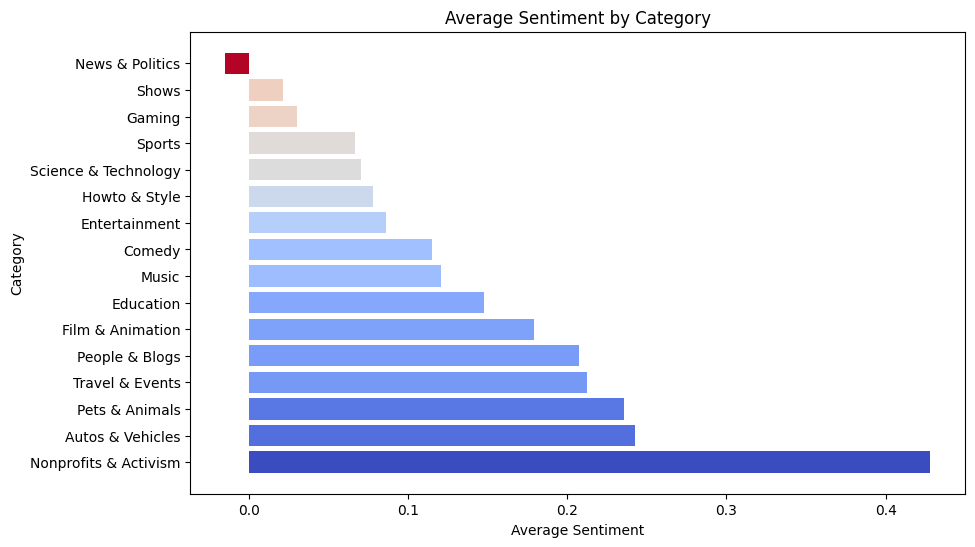

In [21]:
# Creating the bar graph category vs. sentiment
import matplotlib.pyplot as plt

# create a color map
cmap = plt.cm.get_cmap('coolwarm')

# normalize the sentiment values to the range of the color map
norm = plt.Normalize(category['average_sentiment'].min(), category['average_sentiment'].max())

# create a list of colors corresponding to the sentiment values
colors = [cmap(norm(sentiment)) for sentiment in category['average_sentiment']]

# reverse the order of the colors
colors = colors[::-1]

# create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# create the horizontal bar plot
ax.barh(category['names_category'], category['average_sentiment'], color=colors)

# set the axis labels and title
ax.set_xlabel('Average Sentiment')
ax.set_ylabel('Category')
ax.set_title('Average Sentiment by Category')

# show the plots

                   category_id     views  video_likes  dislikes  \
category_id           1.000000 -0.047730    -0.070710 -0.003496   
views                -0.047730  1.000000     0.833721  0.363258   
video_likes          -0.070710  0.833721     1.000000  0.387060   
dislikes             -0.003496  0.363258     0.387060  1.000000   
average_sentiment    -0.143562 -0.073761     0.007740 -0.102489   
sentiment_label      -0.107898  0.028266     0.080162 -0.089410   
tfidf_sum             0.164011  0.136462     0.147714  0.135890   
like_ratio           -0.169446  0.012150     0.259665  0.021167   
dislike_ratio         0.072041  0.017542     0.030148  0.414142   
Likes2Dislikes       -0.078273  0.775598     0.836398  0.124610   

                   average_sentiment  sentiment_label  tfidf_sum  like_ratio  \
category_id                -0.143562        -0.107898   0.164011   -0.169446   
views                      -0.073761         0.028266   0.136462    0.012150   
video_likes           

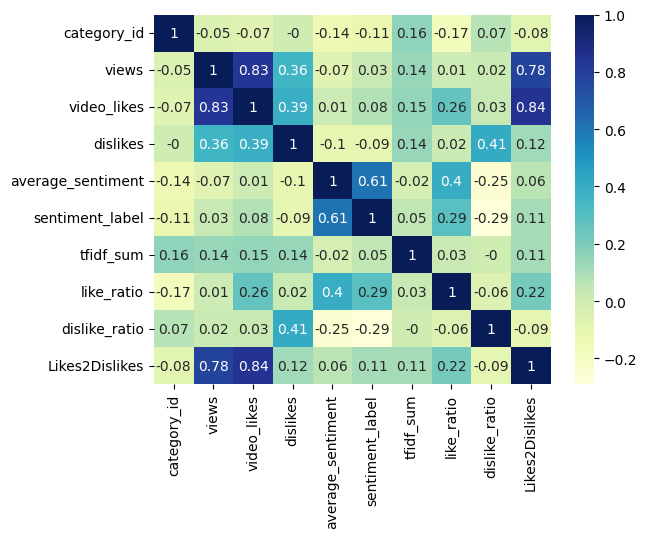

In [27]:
# Creating Correlation Matrix

import matplotlib.pyplot as mp
import seaborn as sb
# columns shown here are selected by corr() since
# they are ideal for the plot
print(df.corr())

# create a correlation matrix of the features
corr_matrix = round(df.corr(), 2)

# create heatmap
sb.heatmap(corr_matrix, annot=True, cmap='YlGnBu')
mp.show()

# Modeling the Dataset


*   Trained and Tested our data
*   Modeling our data



In [28]:
# Splitting the Dataset 

from sklearn.model_selection import train_test_split


# Feature selection based on ChatGPT for Methodology
x = df[['category_id', 'views', 'video_likes', 'dislikes', 'average_sentiment', 'like_ratio', 'dislike_ratio', 'tfidf_sum']]
y = df['sentiment_label']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=True, random_state=42)

print(X_train.shape)
print(y_train.shape)

(1379, 8)
(1379,)


In [29]:
# This is an ensemble learning method that combines multiple decision trees to make predictions. 
# It is useful when there are non-linear relationships between the independent variables and the target variable.
from sklearn.ensemble import RandomForestClassifier

# Define the Random Forest model
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the Random Forest model
clf.fit(X_train, y_train)

# Predict with the Random Forest model
y_pred = clf.predict(X_test)

# Evaluate the Random Forest model
accuracy_rforest = accuracy_score(y_test, y_pred)
accuracy_rforest = round(accuracy_rforest, 4)

print("Accuracy: %.2f" % accuracy_rforest)

Accuracy: 0.97


In [30]:
# This is a powerful regression model that uses a kernel function to map the input data to a higher-dimensional space.
from sklearn import svm

# Define the SVM model
clf = svm.SVC(kernel='rbf')

# Train the SVM model
clf.fit(X_train, y_train)

# Predict with the SVM model
y_pred = clf.predict(X_test)

# Evaluate the SVM model
accuracy_svm = accuracy_score(y_test, y_pred)
accuracy_svm = round(accuracy_svm, 4)


print("Accuracy: %.2f" % accuracy_svm)

Accuracy: 0.86


In [31]:
# This is a simple and widely used regression model that assumes a logistic relationship between the independent variables and the target variable.
from sklearn.linear_model import LogisticRegression

# Define the logistic regression model
clf = LogisticRegression(random_state=42)

# Train the logistic regression model
clf.fit(X_train, y_train)

# Predict with the logistic regression model
y_pred = clf.predict(X_test)

# Evaluate the logistic regression model
accuracy_lr = accuracy_score(y_test, y_pred)
accuracy_lr = round(accuracy_lr, 4)


print("Accuracy: %.2f" % accuracy_lr)

Accuracy: 0.86


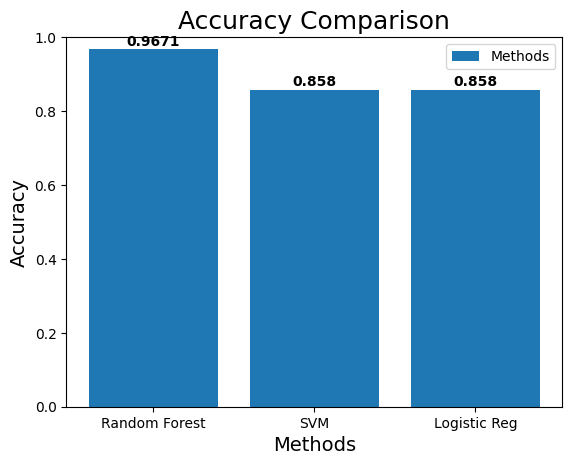

In [32]:
import matplotlib.pyplot as plt

# Define the data
labels = ['Random Forest', 'SVM', 'Logistic Reg']
values = [accuracy_rforest, accuracy_svm, accuracy_lr]

# Create a bar plot with the specified values
fig, ax = plt.subplots()
ax.bar(labels, values)

# Set the plot title and axis labels
ax.set_title('Accuracy Comparison', fontsize=18)
ax.set_xlabel('Methods', fontsize=14)
ax.set_ylabel('Accuracy', fontsize=14)
ax.legend(['Methods'])

# Set the range of the y-axis
ax.set_ylim(0, 1)

# Add annotations for each bar
for i, v in enumerate(values):
    ax.text(i, v + 0.01, str(v), ha='center', fontweight='bold')

# Display the plot
plt.show()

## Final Modeling

In [34]:
# Final modeling with the predicted y into the testing set
final_pred = X_test
final_pred['predicted_sentiment'] = y_pred
final_pred

,category_id,views,video_likes,dislikes,average_sentiment,like_ratio,dislike_ratio,tfidf_sum,predicted_sentiment
387,25,59450,398,63,0.027112,0.006695,0.001060,1.000000,1
1426,24,2746174,78698,13980,-0.016123,0.028657,0.005091,3.326209,0
697,10,2781186,370543,1193,0.245484,0.133232,0.000429,2.512246,1
1739,24,262396,2914,94,0.208382,0.011105,0.000358,4.143615,1
735,22,189698,13351,82,0.239241,0.070380,0.000432,2.980937,1
...,...,...,...,...,...,...,...,...,...
123,17,113400,1049,20,0.257753,0.009250,0.000176,1.726604,1
2193,17,822925,11584,713,0.044986,0.014077,0.000866,1.413067,1
136,25,171000,454,85,0.127661,0.002655,0.000497,2.209042,1
2111,26,347621,17286,237,0.232200,0.049727,0.000682,6.253642,1
